In [24]:
# Support Vector Machine (SVM) - MONK

### Imports   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
import sys
from pathlib import Path

In [25]:
# Import common code (utils)
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import monk_utils as utils
from common.monk_utils import MonkDataset

RANDOM_STATE = 42 

In [26]:
### Data Preparation and Experiment
def run_monk_experiment(train_dataset, test_dataset, id_dataset):
    print(f"\n{'='*20} Processing MONK {id_dataset} (SVM Multiple Trials) {'='*20}")
    
    # 1. Load Data
    X_train_raw, y_train = utils.load_monk_dataset(train_dataset)
    X_test_raw, y_test = utils.load_monk_dataset(test_dataset)
    
    # 2. One-Hot Encoding
    encoder = utils.MonkEncoder()
    X_train = encoder.fit_transform(X_train_raw)
    X_test = encoder.transform(X_test_raw)
    
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    # --- MULTIPLE TRIALS SETUP ---
    N_TRIALS = 10
    trial_train_mses = []
    trial_test_mses = []
    trial_train_accs = []
    trial_test_accs = []
    
    best_params_last_trial = {}

    print(f"Running {N_TRIALS} independent trials (varying CV splits)... ")
    
    for i in range(N_TRIALS):
        current_seed = i * 100 + RANDOM_STATE
        kf = KFold(n_splits=5, shuffle=True, random_state=current_seed)
        
        # --- GRID SEARCH (Inside Trial) ---
        # Tuning C and Kernel (similar to tuning K and weights in KNN)
        c_values = [0.1, 1, 10, 100]
        kernel_options = ['linear', 'rbf', 'poly']
        
        best_score = -np.inf
        best_params = {}
        
        for kernel in kernel_options:
            for c in c_values:
                fold_accs = []
                for train_idx, val_idx in kf.split(X_train):
                    # Split
                    X_fold_tr, X_fold_val = X_train[train_idx], X_train[val_idx]
                    y_fold_tr, y_fold_val = y_train[train_idx], y_train[val_idx]
                    
                    # Train & Eval
                    model = SVC(C=c, kernel=kernel, random_state=RANDOM_STATE)
                    model.fit(X_fold_tr, y_fold_tr)
                    preds = model.predict(X_fold_val)
                    fold_accs.append(utils.calc_accuracy(y_fold_val, preds))
                
                avg_acc = np.mean(fold_accs)
                if avg_acc > best_score:
                    best_score = avg_acc
                    best_params = {'C': c, 'kernel': kernel}
        
        # --- FINAL EVALUATION FOR THIS TRIAL ---
        final_model = SVC(**best_params, random_state=RANDOM_STATE)
        final_model.fit(X_train, y_train)
        
        tr_pred = final_model.predict(X_train)
        ts_pred = final_model.predict(X_test)
        
        trial_train_mses.append(utils.calc_mse(y_train, tr_pred))
        trial_test_mses.append(utils.calc_mse(y_test, ts_pred))
        trial_train_accs.append(utils.calc_accuracy(y_train, tr_pred))
        trial_test_accs.append(utils.calc_accuracy(y_test, ts_pred))
        
        if i == N_TRIALS - 1:
            best_params_last_trial = best_params

    # --- PLOTTING (Based on the Best Params of the Last Trial) ---
    plot_c_values = [0.01, 0.1, 1, 10, 100, 500, 1000]
    plot_train_accs, plot_test_accs = [], []
    plot_train_mses, plot_test_mses = [], []
    
    best_kernel = best_params_last_trial['kernel']
    
    for c in plot_c_values:
        model = SVC(C=c, kernel=best_kernel, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        tr_p = model.predict(X_train)
        ts_p = model.predict(X_test)
        
        plot_train_accs.append(utils.calc_accuracy(y_train, tr_p))
        plot_test_accs.append(utils.calc_accuracy(y_test, ts_p))
        plot_train_mses.append(utils.calc_mse(y_train, tr_p))
        plot_test_mses.append(utils.calc_mse(y_test, ts_p))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # MSE Plot
    ax1.plot(plot_c_values, plot_train_mses, label='Train MSE', marker='o')
    ax1.plot(plot_c_values, plot_test_mses, label='Test MSE', marker='x', linestyle='--')
    ax1.set_xscale('log')
    ax1.set_title(f'MONK {id_dataset}: MSE vs C (kernel={best_kernel})')
    ax1.set_xlabel('C (Penalty parameter)')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy Plot
    ax2.plot(plot_c_values, plot_train_accs, label='Train Acc', marker='o')
    ax2.plot(plot_c_values, plot_test_accs, label='Test Acc', marker='x', linestyle='--')
    ax2.set_xscale('log')
    ax2.set_title(f'MONK {id_dataset}: Accuracy vs C (kernel={best_kernel})')
    ax2.set_xlabel('C (Penalty parameter)')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

    # --- FINAL REPORT ---
    print(f"FINAL REPORT for MONK {id_dataset} (SVM - {N_TRIALS} Trials)")
    print(f"MSE (Train):      {np.mean(trial_train_mses):.4f} ± {np.std(trial_train_mses):.4f}")
    print(f"MSE (Test):       {np.mean(trial_test_mses):.4f}  ± {np.std(trial_test_mses):.4f}")
    print(f"Accuracy (Train): {np.mean(trial_train_accs):.2%} ± {np.std(trial_train_accs):.2%}")
    print(f"Accuracy (Test):  {np.mean(trial_test_accs):.2%}  ± {np.std(trial_test_accs):.2%}")
    print(f"Most Frequent Best Params (Last Trial): {best_params_last_trial}")


==================== Processing MONK 1 (SVM Multiple Trials) ====================
Train shape: (124, 17), Test shape: (432, 17)
Running 10 independent trials (varying CV splits)... 


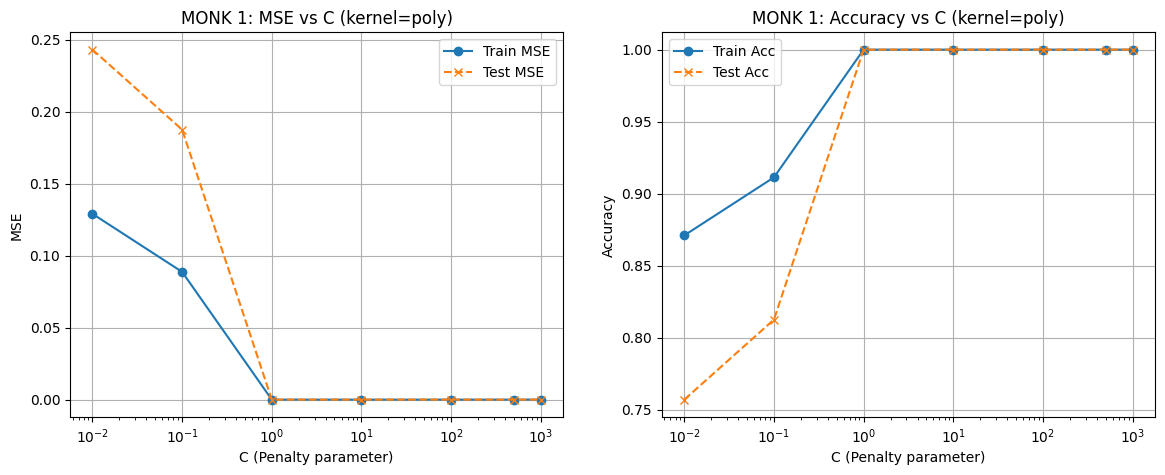

FINAL REPORT for MONK 1 (SVM - 10 Trials)
MSE (Train):      0.0000 ± 0.0000
MSE (Test):       0.0000  ± 0.0000
Accuracy (Train): 100.00% ± 0.00%
Accuracy (Test):  100.00%  ± 0.00%
Most Frequent Best Params (Last Trial): {'C': 1, 'kernel': 'poly'}

==================== Processing MONK 2 (SVM Multiple Trials) ====================
Train shape: (169, 17), Test shape: (432, 17)
Running 10 independent trials (varying CV splits)... 


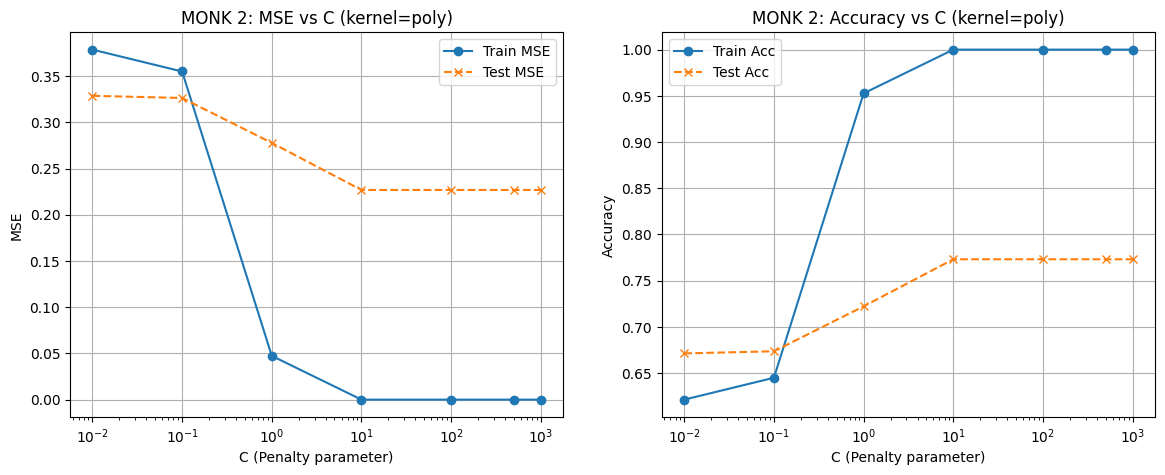

FINAL REPORT for MONK 2 (SVM - 10 Trials)
MSE (Train):      0.0450 ± 0.1050
MSE (Test):       0.2470  ± 0.0332
Accuracy (Train): 95.50% ± 10.50%
Accuracy (Test):  75.30%  ± 3.32%
Most Frequent Best Params (Last Trial): {'C': 10, 'kernel': 'poly'}

==================== Processing MONK 3 (SVM Multiple Trials) ====================
Train shape: (122, 17), Test shape: (432, 17)
Running 10 independent trials (varying CV splits)... 


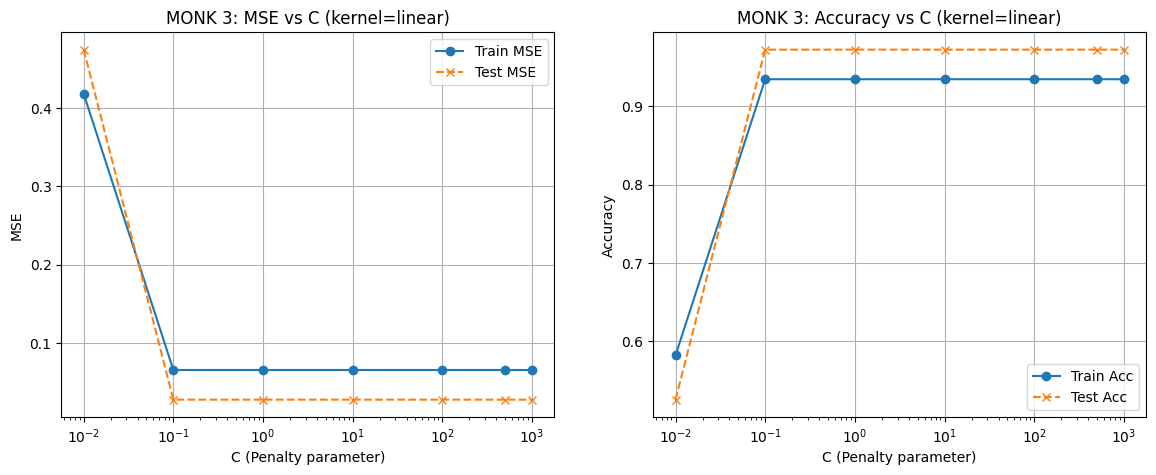

FINAL REPORT for MONK 3 (SVM - 10 Trials)
MSE (Train):      0.0656 ± 0.0000
MSE (Test):       0.0278  ± 0.0000
Accuracy (Train): 93.44% ± 0.00%
Accuracy (Test):  97.22%  ± 0.00%
Most Frequent Best Params (Last Trial): {'C': 0.1, 'kernel': 'linear'}


In [27]:
# Main Execution
run_monk_experiment(train_dataset=MonkDataset.MONK1_TRAIN, test_dataset=MonkDataset.MONK1_TEST, id_dataset=1)
run_monk_experiment(train_dataset=MonkDataset.MONK2_TRAIN, test_dataset=MonkDataset.MONK2_TEST, id_dataset=2)
run_monk_experiment(train_dataset=MonkDataset.MONK3_TRAIN, test_dataset=MonkDataset.MONK3_TEST, id_dataset=3)